In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

In [2]:
# Read the arrays that were prepared separately
# b_pdf    = the default background hist pdf 
# b1_pdf   = 1st alternative to hist b_pdf
# b2_pdf   = 2nd alternative to hist b_pdf
# s_pdf    = the hist pdf for signal
# d        = the hist for the data
# binCen   = the center of the hist bins
# binEdges = the edges of the bins
# The arrays were saved with this command:
# np.savez("histForMinuitFit.npz", b_pdf, b1_pdf, b2_pdf, 
#           s_pdf, d, binCen, binEdges,
#           b_pdf=b_pdf, b1_pdf=b1_pdf, b2_pdf=b2_pdf, 
#           s_pdf=s_pdf, d=d,
#           binCen=binCen, binEdges=binEdges)
npzfile  = np.load("histForMinuitFit.npz")
b_pdf    = npzfile['b_pdf']
b1_pdf   = npzfile['b1_pdf']
b2_pdf   = npzfile['b2_pdf']
s_pdf    = npzfile['s_pdf']
d        = npzfile['d']
binCen   = npzfile['binCen']
binEdges = npzfile['binEdges']

In [3]:
# All pdfs should already be normalized to 1.
# But just in case, normalize them again
b_pdf  = b_pdf  / b_pdf.sum()
b1_pdf = b1_pdf / b1_pdf.sum()
b2_pdf = b2_pdf / b2_pdf.sum()
s_pdf  = s_pdf  / s_pdf.sum()

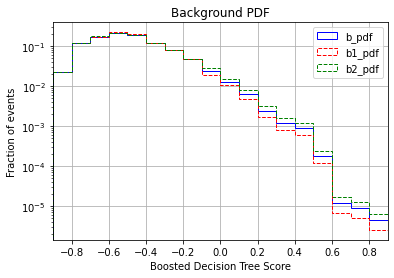

In [4]:
a1 = plt.subplot(111)
a1.hist(binCen,binEdges,weights=b_pdf, 
        histtype='step', log=True, color='blue', label="b_pdf")
a1.hist(binCen,binEdges,weights=b1_pdf, 
        histtype='step', linestyle='dashed', log=True, color='red', label="b1_pdf")
a1.hist(binCen,binEdges,weights=b2_pdf, 
        histtype='step', linestyle='dashed', log=True, color='green', label="b2_pdf")
a1.set_xlim(binEdges[0], binEdges[-1])
a1.set_title("Background PDF")
a1.set_xlabel("Boosted Decision Tree Score")
a1.set_ylabel("Fraction of events")
a1.legend()
a1.grid()

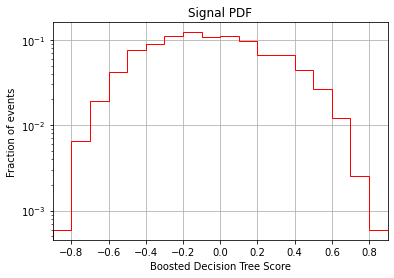

In [5]:
a2 = plt.subplot(111)
a2.hist(binCen,binEdges,weights=s_pdf, histtype='step', log=True, color='red')
a2.set_xlim(binEdges[0], binEdges[-1])
a2.set_title("Signal PDF")
a2.set_xlabel("Boosted Decision Tree Score")
a2.set_ylabel("Fraction of events")
a2.grid()

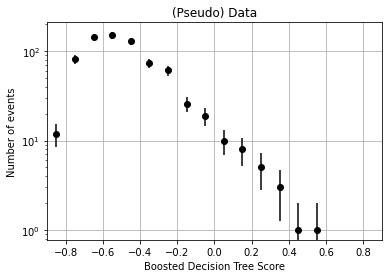

In [6]:
a4 = plt.subplot(111)
# c4, b4, _ = a4.hist(binCen, binEdges, weights=d, log=True, color='black', histtype='step')
a4.errorbar(binCen, d, yerr=np.sqrt(d), linestyle="none", color='black',
                marker='o')
a4.set_yscale('log')
a4.set_xlim(binEdges[0], binEdges[-1])
a4.set_xlabel("Boosted Decision Tree Score")
a4.set_ylabel("Number of events")
a4.set_title("(Pseudo) Data")
a4.grid()

In [7]:
# Define a class to hold the data, the pdfs, and the NLL function
# Gets the "morphed" BG pdf using the method of Section 4 in
# https://indico.cern.ch/event/107747/contributions/32677/attachments/24368/35057/conway.pdf
# Let f be the nuisance parameter associated with morphing
# For abs(f)<1 we have quadratic approximation
#     b = 0.5*f*(f-1)*bg1 - (f-1)*(f+1)*bg + 0.5*f(f+1)*bg2
# For abs(f)>1 we linearly extrapolate
# Note:
# db/df = (f-0.5)*bg1 - 2*f*bg + (f+0.5)*bg2
# --> db/df at f=-1 : -1.5*bg1 + 2*bg - 0.5*bg2
# --> fb/df at f=1  :  0.5*bg1 - 2*bg + 1.5*bg2
class myFit:
    def __init__(self, data, sig_pdf, bg_pdf, bg1_pdf, bg2_pdf):
        self.data     = data
        self.sig_pdf  = sig_pdf
        self.bg_pdf   = bg_pdf
        self.bg1_pdf  = bg1_pdf
        self.bg2_pdf  = bg2_pdf

    def getMorphedPdf(self, f):
        if abs(f) <= 1.:
            morph = 0.5*f*(f-1)*self.bg1_pdf - (f-1)*(f+1)*self.bg_pdf  + 0.5*f*(f+1)*self.bg2_pdf
        elif f>1:
            slope = 0.5*self.bg1_pdf - 2*self.bg_pdf + 1.5*self.bg2_pdf
            morph = self.bg2_pdf + (f-1)*slope
        else:
            slope = -1.5*self.bg1_pdf + 2*self.bg_pdf - 0.5*self.bg2_pdf
            morph = self.bg1_pdf + (f+1)*slope
        return morph/morph.sum()
                                       
    def NLL(self, p):
        S         = p[0]
        B         = p[1]
        alpha     = p[2]
        new_b_pdf = self.getMorphedPdf(alpha)
        temp = self.data * np.log(S*s_pdf + B*new_b_pdf)
        return S + B - temp.sum() + alpha*alpha/2.

In [8]:
# Instantiate the class
thisFit = myFit(d, s_pdf, b_pdf, b1_pdf, b2_pdf)

# Initialize the parameters (order is S,B,alpha)
pinit     = np.array([10, 500, 0])
m = Minuit(thisFit.NLL, pinit, name=("S", "B", "alpha"))
m.errordef = Minuit.LIKELIHOOD
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2516                      │              Nfcn = 72               │
│ EDM = 1.22e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ S     │    20     │    12     │            │            │         │         │       │
│ 1 │ B     │    705    │    29     │            │            │         │         │       │
│ 2 │ alpha │    0.4    │    0.8    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     S     B alpha │
├───────┼───────────────────┤
│     S │   140  -120 -4.72 │
│     B │  -120   825  4.71 │
│ alpha │ -4.72  4.71 0.568 │
└───────┴───────────────────┘

In [9]:
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2516                      │              Nfcn = 209              │
│ EDM = 1.22e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ S     │    20     │    12     │    -11     │     13     │         │         │       │
│ 1 │ B     │    705    │    29     │    -28     │     29     │         │         │       │
│ 2 │ alpha │    0.4    │    0.8    │    -0.8    │    0.7     │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │           S           │           B           │         alpha         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -11    │    13     │    -28    │    29     │   -0.8    │    0.7    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬───────────────────┐
│       │     S     B alpha │
├───────┼───────────────────┤
│     S │   140  -120 -4.72 │
│     B │  -120   825  4.71 │
│ alpha │ -4.72  4.71 0.568 │
└───────┴───────────────────┘

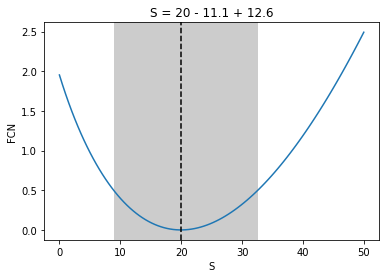

In [10]:
# Profile log likelihood (crappy plot)
S_scan, loglik = m.draw_mnprofile("S",size=100, bound=[0,50], subtract_min=True)

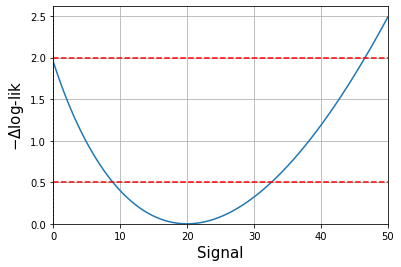

In [11]:
# Redraw it prettier
ax = plt.subplot(111)
ax.plot(S_scan,loglik)
ax.set_xlim(S_scan[0], S_scan[-1])
ax.set_ylim(bottom=0)
ax.grid()
ax.plot([0,0],[0,ax.get_ylim()[1]], color='black',linestyle='dotted')
ax.plot([S_scan[0], S_scan[-1]], [0.5, 0.5], color='red', linestyle='dashed')
ax.plot([S_scan[0], S_scan[-1]], [2.0, 2.0], color='red', linestyle='dashed')
ax.set_xlabel("Signal", size=15)
_ = ax.set_ylabel("$-\Delta$log-lik", size=15)

In [12]:
# get fit parameters
fittedB = m.values['B']
fittedS = m.values['S']
fitteda = m.values['alpha']
if fitteda>0:
    bf_pdf = b_pdf + fitteda*(b1_pdf-b_pdf)
else:
    bf_pdf = b_pdf - fitteda*(b2_pdf-b_pdf)
bf_pdf = bf_pdf / bf_pdf.sum()


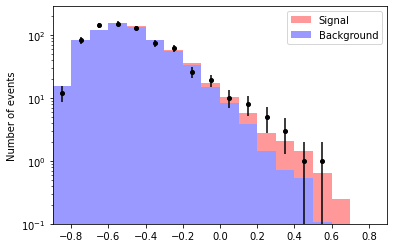

In [13]:
# Then plot stacked histograms of S and B
# lists with the data, colors, and labels of the two hist 
blah   = [binCen, binCen]
colors = ['blue', 'red']
names  = ['Background', 'Signal']
w2     = [fittedB*bf_pdf, fittedS*s_pdf]

ax42 = plt.subplot(111)
ax42.hist(blah, binEdges, histtype='stepfilled', log=True,
          color=colors, stacked='True', label=names, weights=w2, alpha=0.4)
ax42.errorbar(binCen, d, yerr=np.sqrt(d), linestyle='none', marker='o', 
              color='black', markersize=4)
ax42.set_ylim(0.1)
ax42.set_xlim(binEdges[0], binEdges[-1])
ax42.legend()
_ = ax42.set_ylabel("Number of events")
